# Sensitivity test

In [1]:
notebook_name = "sensitivity_test"

In [2]:
path_for_repo=f"/data37/kanon/modern_model_comparison"

In [3]:
import os, pathlib, sys, warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import colormaps
import itertools
warnings.simplefilter('ignore')

In [4]:
# Original modules
from save_figure_with_confirmation import save_figure_with_confirmation as save_fig

iso_model_dir = pathlib.Path(f"{path_for_repo}/scripts/IsoFracPy").resolve()
sys.path.append(str(iso_model_dir))
from main import (
    configure_model, 
    initialization, 
    get_fractionation_factors,
    process_vapor_isotopes
)
from IsotopeFractionationModel import (
    plot_q_dq,
    sat_specific_humidity,
)

In [5]:
def run_sensitivity_analysis(
    param_test_dict: dict,
    param_fix_dict: dict = None,
    xlim: tuple = (0, 10),
    ylim: tuple = (-300, -50),
    fig_size_unit: tuple = (5, 5),
    subplot_hnum_max = 4,
    fig_title: str = "General Sensitivity Analysis",
    iso_model_dir: str = ".",
    results_dir: str = "analysis", 
    BOOL_SAVE_FIG: bool = True,    
    notebook_name: str = None,
):    
    """
    Do sensitivity analysis by varing parameters and plotting results.

    Parameters:
    - param_test_dict (dict): Dictionary of parameters to vary with their values.
    - param_fix_dict (dict, optional): Dictionary of fixed parameters. Default is None.
    - xlim (tuple): x-axis limits for the plots. Default is (0, 10).
    - ylim (tuple): y-axis limits for the plots. Default is (-300, -50).
    - fig_size_unit (tuple): Unit size for each subplot (width, height). Default is (5, 5).
    - subplot_hnum_max (int): Maximum number of subplots in a row. Default is 4.
    - fig_title (str): Title for the entire figure. Default is "General Sensitivity Analysis".
    - iso_model_dir (str): Base directory for the isotope model. Default is ".".
    - results_dir (str): Subdirectory to save analysis results. Default is "analysis".
    - BOOL_SAVE_FIG (bool): Whether save figure or not. Default is True.
    - notebook_name (str): Name of executing notebook name. Default is "".

    Methods:
    - Generate parameter combinations.
    - Configure and execute the model for each combination.
    - Plot the results for each combination in subplots.
    - Save the final figure to specified directory.

    Returns:
    - None: The function directly displays the plots and saves the figure.
    """
    param_combinations, num_of_analysis = prepare_parameter_combinations(
        param_test_dict
    )

    num_of_plot_x, num_of_plot_y = calculate_subplot_grid(num_of_analysis, subplot_hnum_max)
    fig, gs = initialize_figure(fig_title, fig_size_unit, num_of_plot_x, num_of_plot_y)
    
    for index, combination in enumerate(param_combinations):
        # Configure the model
        config = configure_model_with_params(param_fix_dict, param_test_dict, combination)
        plot_results_for_combination(
            config, index, combination, param_test_dict.keys(), 
            fig, gs, subplot_hnum_max, xlim, ylim, num_of_analysis
        )

    finalize_and_save_figure(fig, fig_title, iso_model_dir, results_dir, BOOL_SAVE_FIG, notebook_name)


def prepare_parameter_combinations(parm_test_dict: dict) -> tuple:
    """
    Prepare parameter combinations for sensitivity analysis.

    Parameters:
    - param_test_dict (dict): Dictionary of parameters to vary with their values.

    Returns:
    - tuple:
        - list: List of parameter combinations.
        - int: Number of combinations.
    """    
    param_combinations = list(itertools.product(*param_test_dict.values()))
    return param_combinations, len(param_combinations)

def calculate_subplot_grid(num_of_analysis: int, subplot_hnum_max: int) -> tuple:
    """
    Calculate the grid size for subplots.

    Parameters:
    - num_of_analysis (int): Total number of analyses.
    - subplot_hnum_max (int): Maximum number of subplots in a row.

    Returns:
    - tuple: Number of plots along x and y axes.
    """
    num_of_plot_x = subplot_hnum_max if num_of_analysis >=subplot_hnum_max else num_of_analysis 
    num_of_plot_y = num_of_analysis//subplot_hnum_max + 1 if num_of_analysis >subplot_hnum_max else 1
    return num_of_plot_x, num_of_plot_y

def initialize_figure(
    fig_title: str, 
    fig_size_unit: tuple, 
    num_of_plot_x: int,
    num_of_plot_y: int,
):
    """
    Initialize the figure for sensitivity analysis.

    Parameters:
    - fig_title (str): Title for the entire figure.
    - fig_size_unit (tuple): Unit size for each subplot (width, height).
    - num_of_plot_x (int): Number of subplots in a row.
    - num_of_plot_y (int): Number of subplots in a column.

    Returns:
    - tuple:
        - matplotlib.figure.Figure: Initialized figure object.
        - matplotlib.gridspec.GridSpec: GridSpec object for subplots.
    """    
    fig = plt.figure(
        layout="tight", 
        figsize=(fig_size_unit[0] * num_of_plot_x, fig_size_unit[1] * num_of_plot_y)
    )
    fig.suptitle(fig_title, y=1.02)
    gs = GridSpec(num_of_plot_y, num_of_plot_x, figure=fig)
    return fig, gs

def configure_model_with_params(param_fix_dict: dict, param_test_dict: dict, combination: tuple) -> dict:
    """
    Configure the model with the given parameter combination.

    Parameters:
    - param_fix_dict (dict): Fixed parameters.
    - param_test_dict (dict): Test parameters to vary.
    - combination (tuple): Specific parameter combination.

    Returns:
    - dict: Configuration dictionary for the model.    
    """
    config = configure_model()
    if param_fix_dict:
        config.update(param_fix_dict)
        
    for param, value in zip(param_test_dict.keys(), combination):
        config[param] = value
    return config

def plot_results_for_combination(
    config: dict, 
    index: int, 
    combination: tuple, 
    param_names, 
    fig, 
    gs, 
    subplot_hnum_max: int, 
    xlim: tuple, 
    ylim: tuple, 
    num_of_analysis: int
):
    """
    Plot results for a specific parameter combination.

    Parameters:
    - config (dict): Configuration dictionary for the model.
    - index (int): Index of the current combination.
    - combination (tuple): Current parameter combination.
    - param_names (iterable): Names of parameters being tested.
    - fig (matplotlib.figure.Figure): Figure object.
    - gs (matplotlib.gridspec.GridSpec): GridSpec object for subplots.
    - subplot_hnum_max (int): Maximum number of subplots in a row.
    - xlim (tuple): x-axis limits for the plot.
    - ylim (tuple): y-axis limits for the plot.
    - num_of_analysis (int): Total number of analyses.

    Returns:
    - None: Modifies the plot directly.
    """    
    initial_dict = initialization(config)
    frac_factors_dict, alpha_mode_list = get_fractionation_factors(config)

    rayleigh_results_dict, post_precipitation_results_dict = process_vapor_isotopes(
        config, initial_dict, frac_factors_dict, alpha_mode_list
    )

    title = f"({chr(ord('a') + index)}) "+ "".join(
            [f"{param}={val}," for param, val in zip(param_names, combination)]
        )
    title = title[:-1]
    ax = fig.add_subplot(gs[index // subplot_hnum_max, index % subplot_hnum_max])
    ax.set_title(title, loc="left")                

    plot_q_dq(
        config,
        rayleigh_results_dict, 
        post_precipitation_results_dict, 
        ISO_TYPE=config["ISO_TYPE"], 
        title=title, 
        xlim=xlim, 
        ylim=ylim, 
        num_of_subplot=num_of_analysis, 
        ax=ax)
    plt.legend()

def finalize_and_save_figure(fig, fig_title, iso_model_dir, results_dir, BOOL_SAVE_FIG, notebook_name):    
    """
    Finalize the figure layout and save it to the results directory.

    Parameters:
    - fig (matplotlib.figure.Figure): Figure object.
    - fig_title (str): Title for the figure.
    - iso_model_dir (str): Base directory for the isotope model.
    - results_dir (str): Subdirectory to save analysis results.
    - BOOL_SAVE_FIG (bool): Whether save figure or not. Default is True.
    - notebook_name (str): Name of this notebook.

    Returns:
    - None: Saves the figure to disk if `BOOL_SAVE_FIG` is True.
    """    
    # plt.tight_layout(rect=[0, 0, 1, 0.98]) # [left, bottom, right, top]
    plt.tight_layout()
    plt.show()

    results_path = os.path.join(iso_model_dir, results_dir)
    os.makedirs(os.path.join(results_path, "figures"), exist_ok=True)

    if BOOL_SAVE_FIG:
        save_fig(
            fig, 
            results_dir=results_path,
            figure_name=fig_title.replace("}", "").replace("{", "").replace("$", "").replace(",", "").replace(" ", "_"),
            notebook_path=f"{os.path.abspath(notebook_name)}.ipynb",
            check_overwrite=False
        )

In [6]:
# def get_temp_init_lists(temp_air_fin, temp_air_max=15, dt=5):
#     if temp_air_fin > 0:
#         raise ValueError(f"temp_air_fin must be equal or lower than 0 °C.")
#     temp_list = np.arange(temp_air_fin, temp_air_max+dt, dt)

#     temp_air_init_list = []
#     temp_sea_init_list = []
#     i=1
#     temp = temp_air_fin
#     while temp < 0:
#         temp = temp_list[i]
#         temp_air_init_list.append(temp)
#         temp_sea_init_list.append(0)
#         i = i + 1

#     while temp < temp_air_max:
#         temp = temp_list[i]
#         temp_air_init_list.append(temp)
#         temp_sea_init_list.append(temp)
#         i = i + 1
        
#     return temp_air_init_list, temp_sea_init_list
    
     
    

## あらかじめ絞れるパラメータ

### temperature of sea surface of initial evaporation

Nakamura et al. 2008 GRL　Fig. 1より、typicalな　SST frontは5-15度くらい。その周辺でstorm track活動が活発になると考える。 -> 蒸発起源SST

In [7]:
param_fix_dict = {
    "temp_air_init_list": [5, 10, 15],
    "temp_sea_init_list": [5, 10, 15]    
}

### raindrop evapoation, kinetic fractionation (supersaturation to ice)

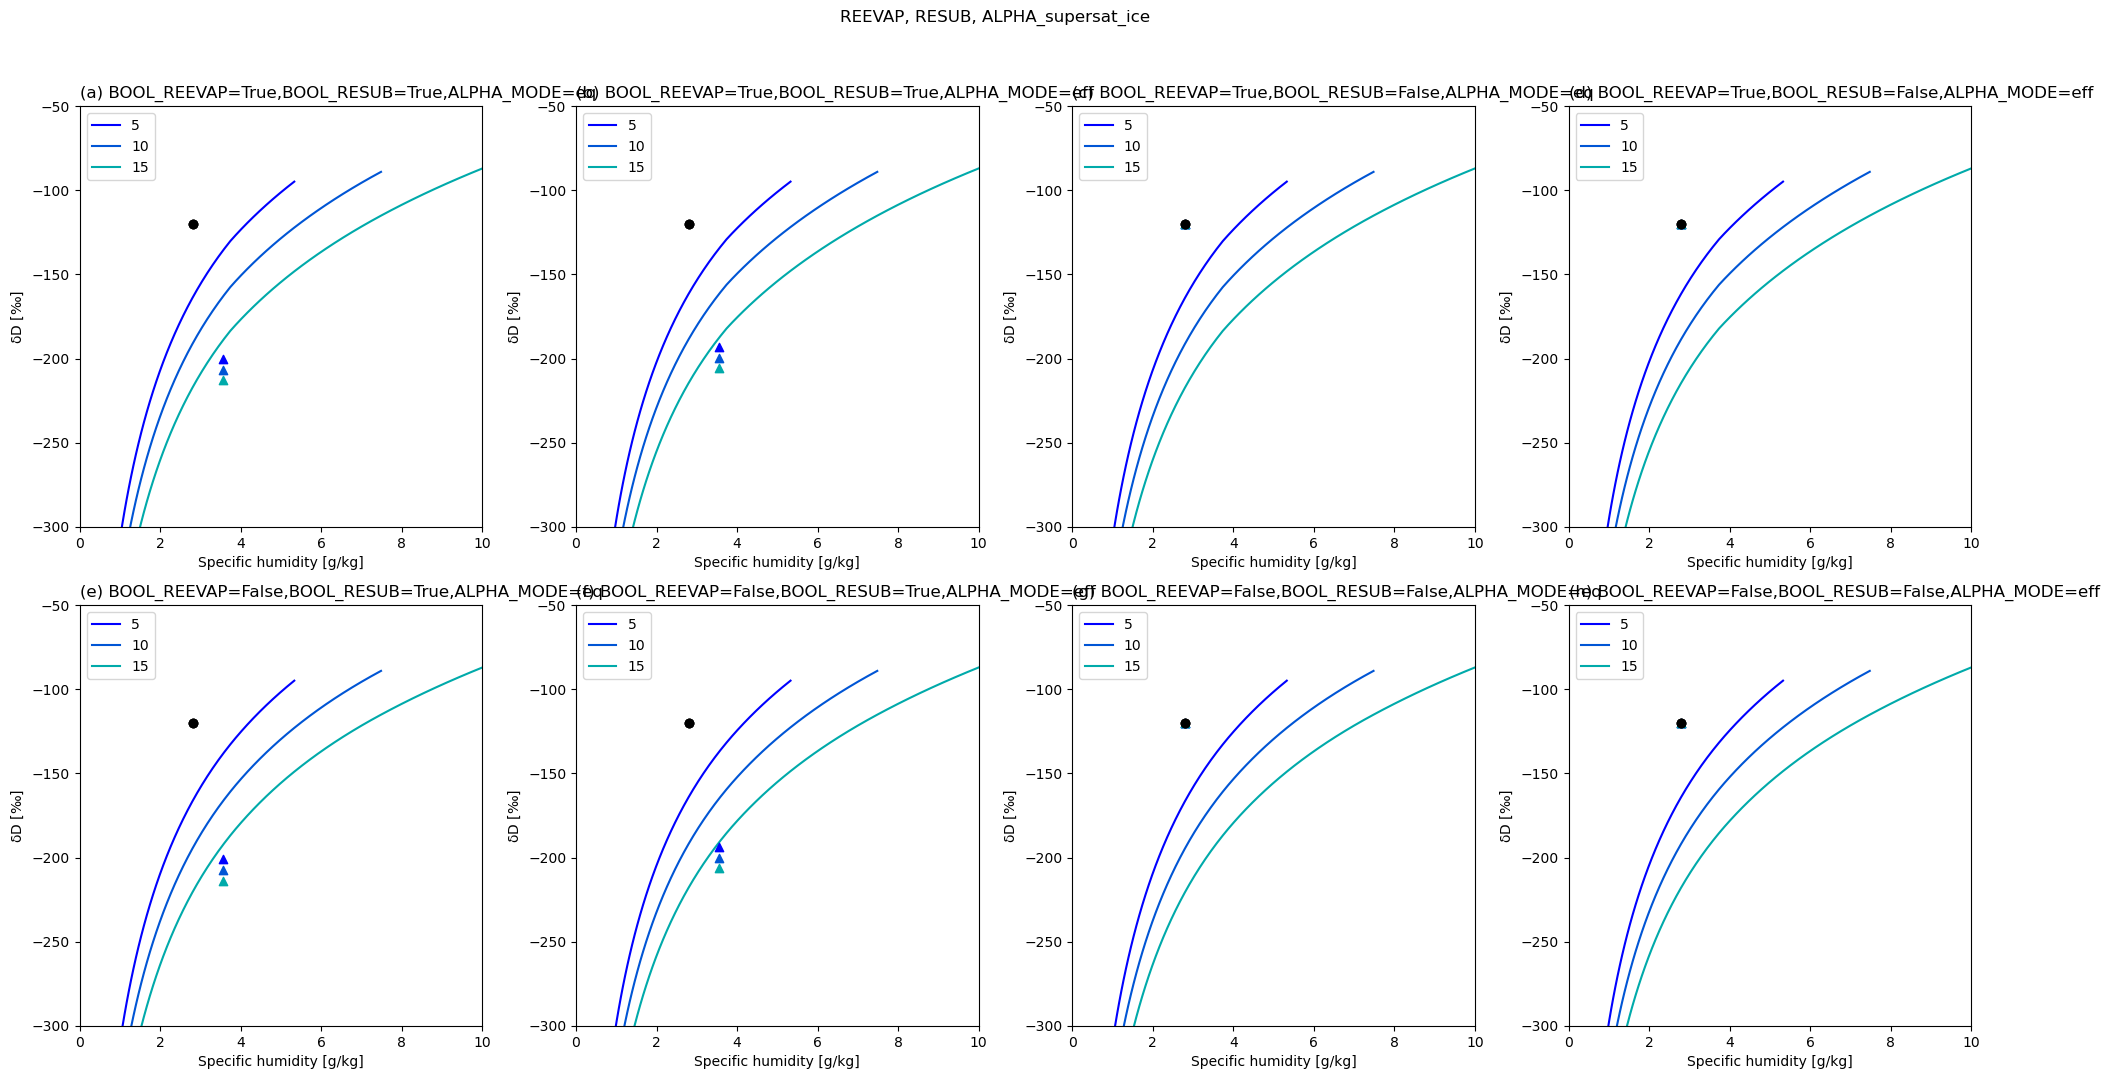

File saved as '/data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/figures/REEVAP_RESUB_ALPHA_supersat_ice.png'.
Logged in /data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/README.md: [REEVAP_RESUB_ALPHA_supersat_ice.png](figures/REEVAP_RESUB_ALPHA_supersat_ice.png) (Generated by /data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/sensitivity_test.ipynb)


In [8]:
param_test_dict = {
    "BOOL_REEVAP": [True, False],
    "BOOL_RESUB": [True, False],
    "ALPHA_MODE": ["eq", "eff"]
}

fig_title="REEVAP, RESUB, ALPHA_supersat_ice"

run_sensitivity_analysis(
    param_test_dict=param_test_dict,
    param_fix_dict=param_fix_dict,
    fig_title=fig_title,
    iso_model_dir=iso_model_dir,
    subplot_hnum_max=4,
    notebook_name=notebook_name
)

`BOOL_REEVAP`(tested for `reevap_factor`=0.7) と`ALPHA_MODE`の影響は考えなくてよさそう。

In [9]:
param_fix_dict["BOOL_RESUB"] = True
param_fix_dict["BOOL_REEVAP"] = False # 十分湿っている雲には返らない
# "reevap_factor"は使われない
param_fix_dict["ALPHA_MODE"] = "eff"

### RH of observation sites

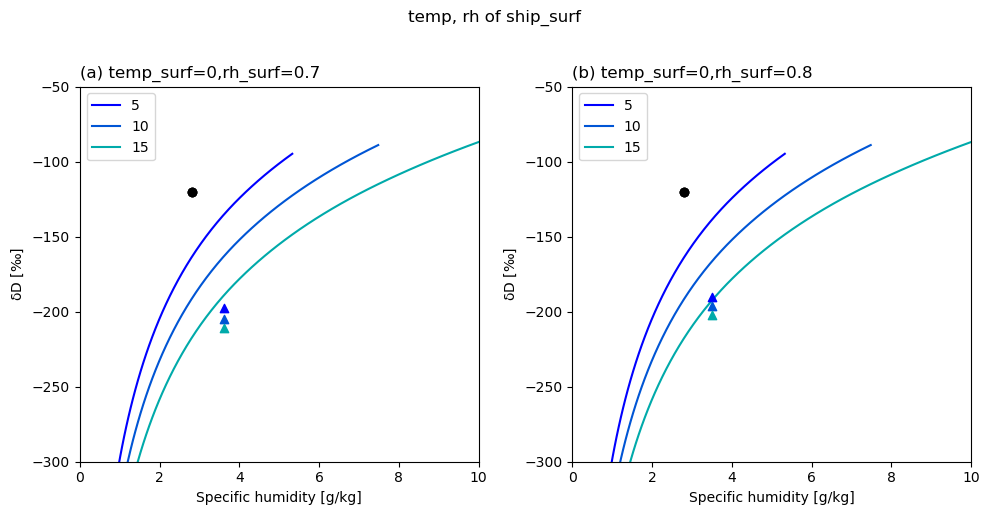

File saved as '/data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/figures/temp_rh_of_ship_surf.png'.
Logged in /data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/README.md: [temp_rh_of_ship_surf.png](figures/temp_rh_of_ship_surf.png) (Generated by /data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/sensitivity_test.ipynb)


In [10]:
param_test_dict = {
    "temp_surf": [0],
    "rh_surf": [0.7,0.8],
}

fig_title="temp, rh of ship_surf"

run_sensitivity_analysis(
    param_test_dict=param_test_dict,
    param_fix_dict=param_fix_dict,
    fig_title=fig_title,
    iso_model_dir=iso_model_dir,
    notebook_name=notebook_name
)

多少影響はあるが、今回みたい違い（20‰くらいの差）に比べ得たら無視できそう。

In [11]:
param_fix_dict["temp_surf"] = 0 # 沿岸でのtypilcalな値
param_fix_dict["rh_surf"] = 0.75 # 沿岸でのtypilcalな値

### q_dD of observation sites

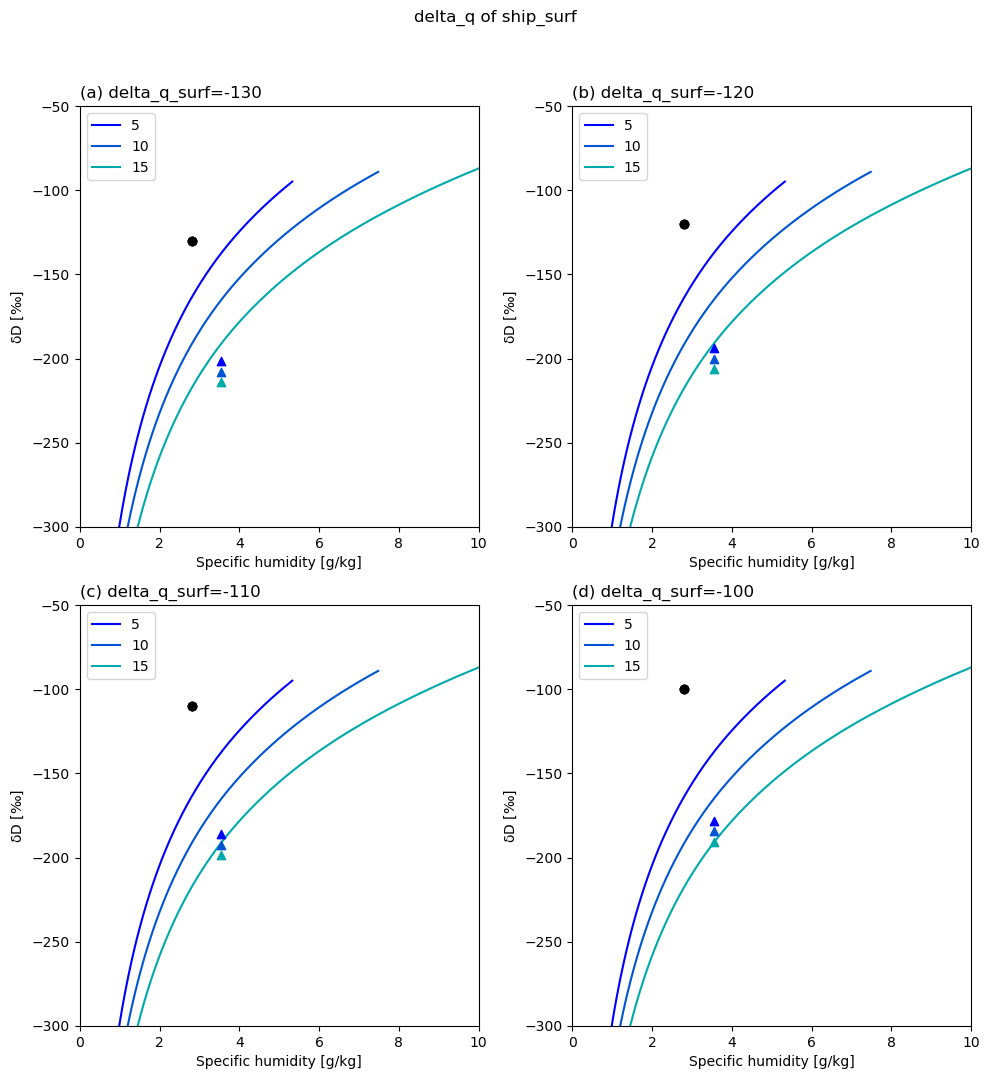

File saved as '/data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/figures/delta_q_of_ship_surf.png'.
Logged in /data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/README.md: [delta_q_of_ship_surf.png](figures/delta_q_of_ship_surf.png) (Generated by /data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/sensitivity_test.ipynb)


In [12]:
param_test_dict = {
    "delta_q_surf":[-130,-120,-110,-100]
}

fig_title="delta_q of ship_surf"

run_sensitivity_analysis(
    param_test_dict=param_test_dict,
    param_fix_dict=param_fix_dict,
    fig_title=fig_title,
    iso_model_dir=iso_model_dir,
    subplot_hnum_max=2,    
    notebook_name=notebook_name
)

多少影響はあるが、今回みたい違い（20‰くらいの差）に比べ得たら無視できそう。

In [13]:
param_fix_dict["delta_q_surf"] = -120 # 沿岸でのtypilcalな値

### Summary

In [14]:
param_fix_dict

{'temp_air_init_list': [5, 10, 15],
 'temp_sea_init_list': [5, 10, 15],
 'BOOL_RESUB': True,
 'BOOL_REEVAP': False,
 'ALPHA_MODE': 'eff',
 'temp_surf': 0,
 'rh_surf': 0.75,
 'delta_q_surf': -120}

## 感度実験の必要なパラメータ

- `temp_air_fin`
- `drh`
- `resub_factor`

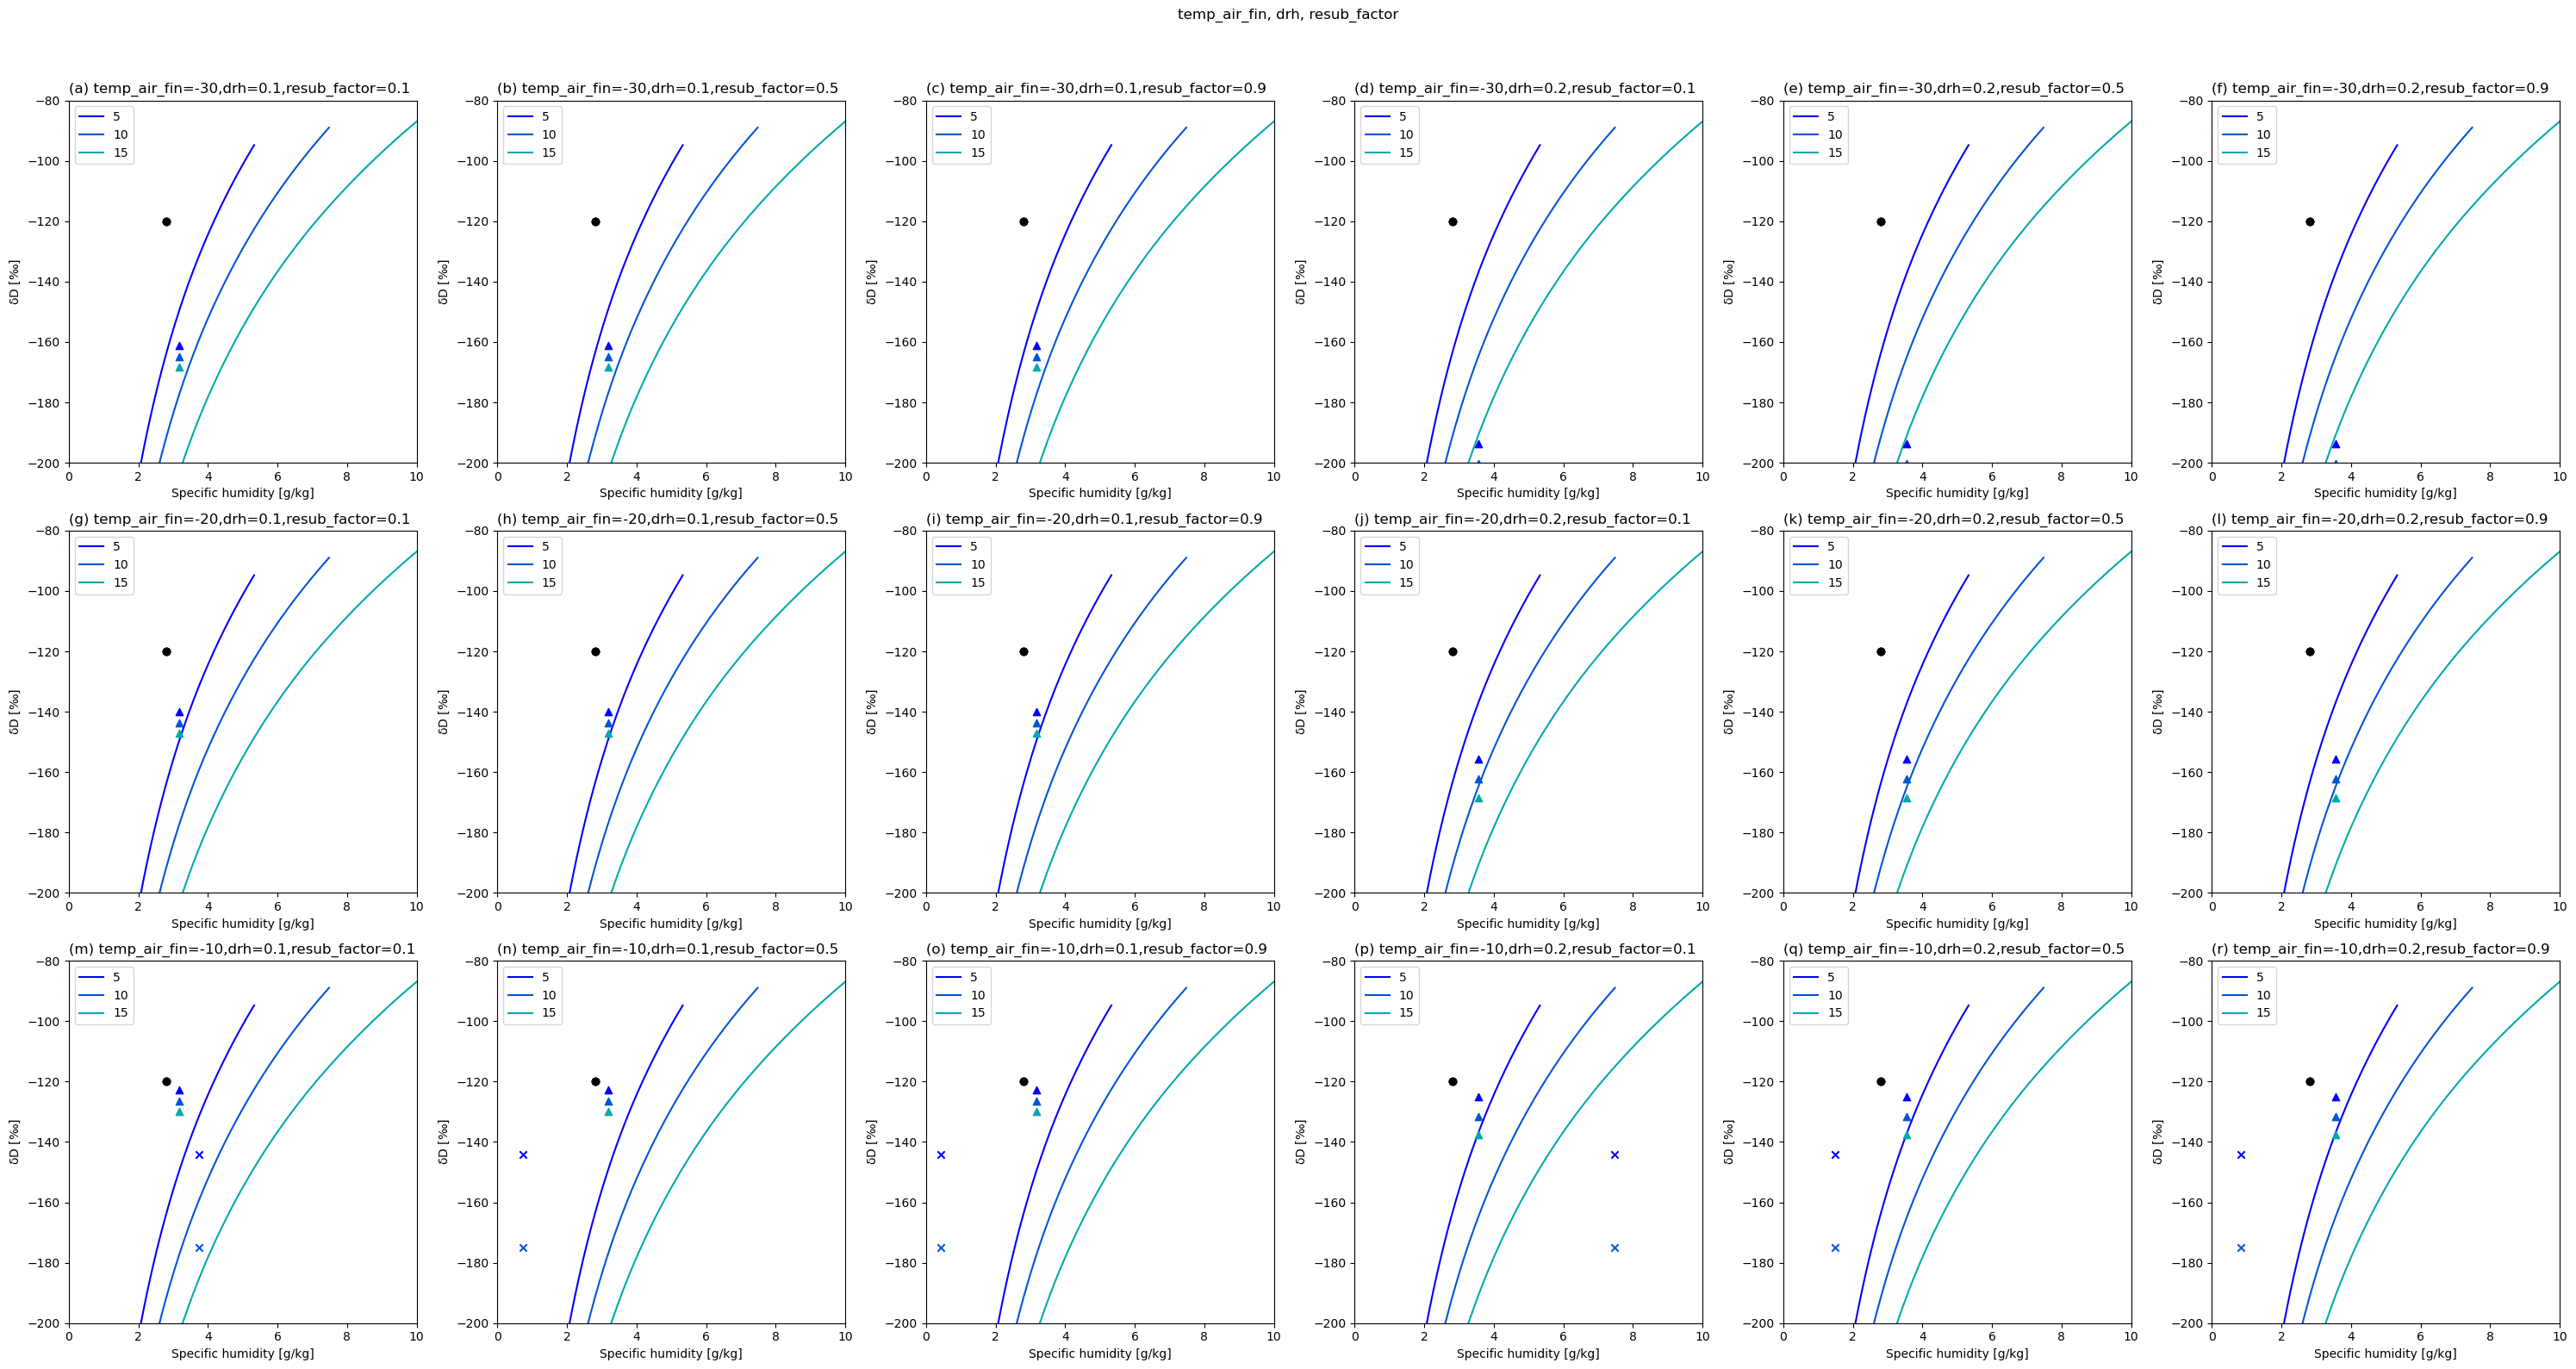

File saved as '/data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/figures/temp_air_fin_drh_resub_factor.png'.
Logged in /data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/README.md: [temp_air_fin_drh_resub_factor.png](figures/temp_air_fin_drh_resub_factor.png) (Generated by /data37/kanon/modern_model_comparison/scripts/IsoFracPy/analysis/sensitivity_test.ipynb)


In [15]:
param_test_dict = {
    "temp_air_fin": [-30, -20, -10],
    "drh":[0.1, 0.2],
    "resub_factor": [0.1, 0.5, 0.9]
}

fig_title="temp_air_fin, drh, resub_factor"
run_sensitivity_analysis(
    param_test_dict=param_test_dict,
    param_fix_dict=param_fix_dict,
    fig_title=fig_title,
    iso_model_dir=iso_model_dir,
    subplot_hnum_max=6,
    xlim = (0, 10),
    ylim = (-200, -80),
    notebook_name=notebook_name
)

どの高さ(`temp_air_fin`)からどれくらい降水が降ってくるか(`drh`)がいちばんききそう。